# The Sparks Foundation - GRIP
## Computer Vision & Internet of Things

# Traffic sign classification/Recognition system

## Implement a traffic sign classifier which identifies the traffic sign

### Created by: Jay Khade

In [1]:
# importing libraries

import numpy as np
import pandas as pd
import random
import os
import glob
import cv2
from skimage import transform
from skimage import io
from skimage import exposure
from sklearn.model_selection import train_test_split
import datetime
import matplotlib.pyplot as plt
import keras
from keras.utils import to_categorical

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, BatchNormalization, MaxPool2D, Activation, Flatten, Dropout, Dense, MaxPooling2D
from keras import optimizers
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator

import warnings
warnings.filterwarnings('ignore')

# Data Reading & Data Understanding 

In [2]:
traffic_sign = pd.read_csv("../input/gtsrb-german-traffic-sign/Train.csv")
print(traffic_sign.shape)
traffic_sign.head()

(39209, 8)


,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId,Path
0,27,26,5,5,22,20,20,Train/20/00020_00000_00000.png
1,28,27,5,6,23,22,20,Train/20/00020_00000_00001.png
2,29,26,6,5,24,21,20,Train/20/00020_00000_00002.png
3,28,27,5,6,23,22,20,Train/20/00020_00000_00003.png
4,28,26,5,5,23,21,20,Train/20/00020_00000_00004.png


- **we have around 39k images for traffic signs.**
- **we can also observe width and height of images are not uniform.**

In [3]:
# checking for classes

print(f"We have {len(traffic_sign.ClassId.unique())} unique classes.")

We have 43 unique classes.


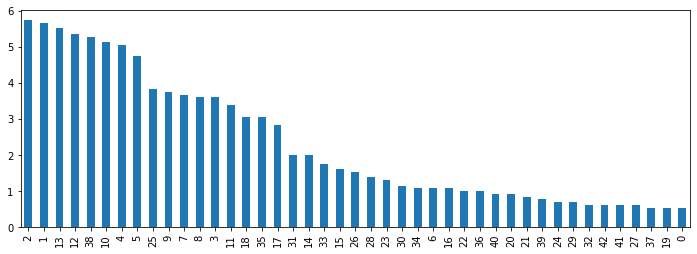

In [4]:
# checking for class distribution

plt.figure(figsize=(12,4))
x = round(traffic_sign.ClassId.value_counts(normalize=True)*100,2).plot(kind='bar')
plt.xticks(rotation='vertical')
plt.show(x)

**We can observe a target imbalance. frequency of some classes is more than the others.**

In [5]:
def load_images_from_folder(folder): 
    images = []
    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder,filename))
        if img is not None:
            images.append(img)
    return images

In [6]:
images_list=load_images_from_folder("../input/gtsrb-german-traffic-sign/Test")

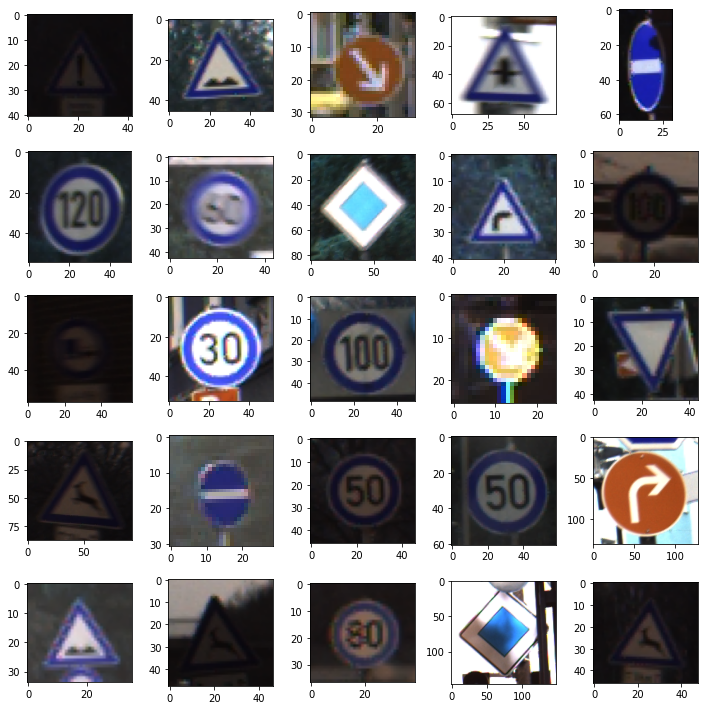

In [7]:
# displaying images

plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    x = images_list[i]
    plt.tight_layout()
    plt.imshow(x)

- **Images available are in low resolution, pixelated.**
- **Have poor contrast, poor lightning.**
- **nedd some preprocessing here.**

## Image Pre-Processing

- **we cant increase the resolution of the images, we have to work with it.**
- **To improve contrast we can use Contrast Limited Adaptive Histogram Equalization (CLAHE).**
- **It is an algorithm for local contrast enhancement, that uses histograms computed over different tile regions of the image. Local details can therefore be enhanced even in regions that are darker or lighter than most of the image.**

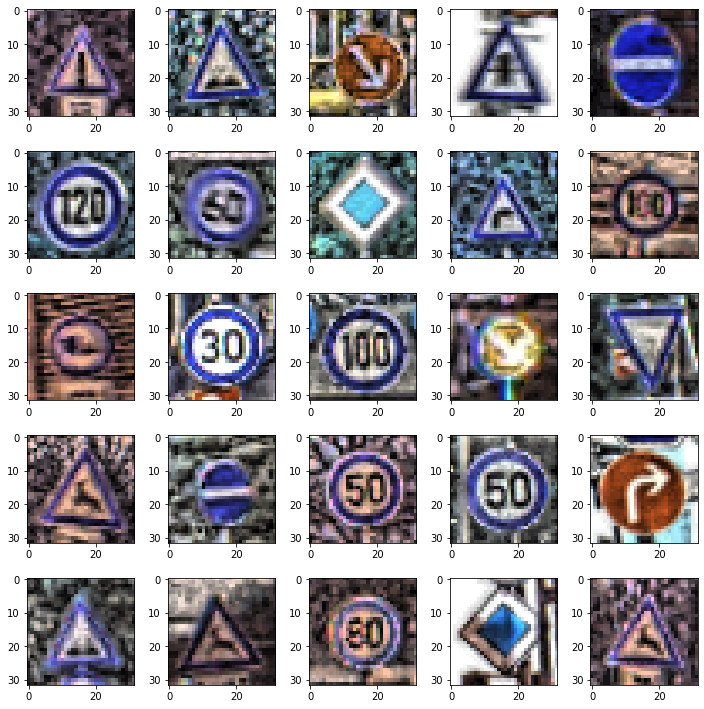

In [8]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    x = images_list[i]
    
    # uniform size
    x =transform.resize(x, (32,32))
    
    #Contrast Limited Adaptive Histogram Equalization
    x = exposure.equalize_adapthist(x,clip_limit=0.1)
    
    plt.tight_layout()
    plt.imshow(x)

**The images may seem a bit unnatural to human eye. But we can observe the changes in the contrast level. In comparison they look far batter now. It will help machine to understand the image in a better way.**

# Loading Data

In [9]:
source_path = "../input/gtsrb-german-traffic-sign"
train_doc = "../input/gtsrb-german-traffic-sign/Train.csv"
test_doc = "../input/gtsrb-german-traffic-sign/Test.csv"

classes = 43
height = 32
width = 32
depth = 3


# initialize the number of epochs to train for, base learning rate,
# and batch size
NUM_EPOCHS = 20
INIT_LR = 0.001
BS = 32

In [10]:
# function to load data

def load_data(basepath, csvpath):
    
    # initialize list of data and labels
    data = []
    labels = []
    
    # skipping header
    rows = open(csvpath).read().strip().split("\n")[1:]
    random.shuffle(rows)
    
    #looping over csv file to extract required information
    
    for (i,row) in enumerate(rows):
        # check to see if we should show a status update
        if i > 0 and i % 10000 == 0:
            print("[INFO] processed {} total images".format(i))
        
        (label, imagepath) = row.strip().split(",")[-2:]
        
        #creating full path of image 
        
        imagepath = os.path.sep.join([basepath,imagepath])
        image = io.imread(imagepath)
        
        # image preprocessing
        # - resizing the images to uniform 32x32 
        # - improve image contrast using contrast limited adaptive histogram equalization
        
        image = transform.resize(image, (32,32))
        image = exposure.equalize_adapthist(image,clip_limit=0.1)
        
        # updating the list of data and labels
        data.append(image)
        labels.append(int(label))
        
    # convert label and data into numpy array
    data = np.array(data)
    labels = np.array(labels)
        
    return data, labels

In [11]:
# collecting and preprocessing train data
data,labels = load_data(basepath="../input/gtsrb-german-traffic-sign", 
                        csvpath="../input/gtsrb-german-traffic-sign/Train.csv")

[INFO] processed 10000 total images
[INFO] processed 20000 total images
[INFO] processed 30000 total images


In [12]:
# collecting and preprocessing test data
data_test , labels_test = load_data(basepath="../input/gtsrb-german-traffic-sign", 
                        csvpath="../input/gtsrb-german-traffic-sign/Test.csv")

[INFO] processed 10000 total images


In [13]:
# train validation splitting

X_train, X_val, y_train, y_val = train_test_split(data, labels, train_size=0.8, shuffle=True, stratify=labels, random_state=42)

# Normalizing Train and validation data

X_train = X_train / 255
X_val = X_val / 255


# Normalizing Test data
X_test = data_test.copy()
y_test = labels_test.copy()
X_test = X_test/255

In [14]:
print(X_train.shape, X_val.shape)
print(y_train.shape, y_val.shape)

(31367, 32, 32, 3) (7842, 32, 32, 3)
(31367,) (7842,)


In [15]:
# creating one hot encoded labels
y_train = to_categorical(y_train, num_classes=classes)
y_val = to_categorical(y_val, num_classes=classes)

In [16]:
# to handle target imbalance

classTotals = y_train.sum(axis=0)
classWeight = classTotals.max() / classTotals

class_weight = {}

for i in enumerate(classWeight):
    
    class_weight[i[0]] = i[1]

print(class_weight)

{0: 10.714286, 1: 1.0135136, 2: 1.0, 3: 1.5957447, 4: 1.1363636, 5: 1.2096775, 6: 5.357143, 7: 1.5625, 8: 1.5957447, 9: 1.5306122, 10: 1.119403, 11: 1.7045455, 12: 1.0714285, 13: 1.0416666, 14: 2.8846154, 15: 3.5714285, 16: 5.357143, 17: 2.0270271, 18: 1.875, 19: 10.714286, 20: 6.25, 21: 6.818182, 22: 5.769231, 23: 4.4117646, 24: 8.333333, 25: 1.5, 26: 3.75, 27: 9.375, 28: 4.1666665, 29: 8.333333, 30: 5.0, 31: 2.8846154, 32: 9.375, 33: 3.2667878, 34: 5.357143, 35: 1.875, 36: 5.769231, 37: 10.714286, 38: 1.0869565, 39: 7.5, 40: 6.25, 41: 9.375, 42: 9.375}


# Model Building

In [17]:
# building CNN Architecture
model = Sequential()
inputShape = (height, width, depth)
chanDim = -1

# CONV => RELU => BN => POOL
model.add(Conv2D(8, (5, 5), padding="same",input_shape=inputShape))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(2, 2)))

# first set of (CONV => RELU => CONV => RELU) * 2 => POOL
model.add(Conv2D(16, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(Conv2D(16, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(2, 2)))


# second set of (CONV => RELU => CONV => RELU) * 2 => POOL
model.add(Conv2D(32, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(Conv2D(32, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(2, 2)))


# first set of FC => RELU layers
model.add(Flatten())
model.add(Dense(128))
model.add(Activation("relu"))
model.add(BatchNormalization())
model.add(Dropout(0.5))
        
# second set of FC => RELU layers
model.add(Flatten())
model.add(Dense(128))
model.add(Activation("relu"))
model.add(BatchNormalization())
model.add(Dropout(0.5))
        
# softmax classifier
model.add(Dense(classes))
model.add(Activation("softmax"))

In [18]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 8)         608       
_________________________________________________________________
activation (Activation)      (None, 32, 32, 8)         0         
_________________________________________________________________
batch_normalization (BatchNo (None, 32, 32, 8)         32        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 8)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 16)        1168      
_________________________________________________________________
activation_1 (Activation)    (None, 16, 16, 16)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 16, 16, 16)        6

In [19]:
# Augmentation- for generating more training data 

aug = ImageDataGenerator(
    rotation_range=10,
    zoom_range=0.15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.15,
    horizontal_flip=False,
    vertical_flip=False,
    fill_mode="nearest")


In [20]:
# using Adam optimizer with decay
# using cross-entropy as loss function and evalution matrix is accuracy

opt = optimizers.Adam(lr=INIT_LR, decay=INIT_LR / (NUM_EPOCHS * 0.5))
model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

In [21]:
# Training

H = model.fit_generator(
    aug.flow(X_train, y_train, batch_size=BS),
    validation_data=(X_val, y_val),
    steps_per_epoch=X_train.shape[0] // BS,
    epochs=NUM_EPOCHS,
    class_weight=class_weight,
    verbose=1,use_multiprocessing=True)

Epoch 1/20
980/980 [==============================] - 35s 31ms/step - loss: 9.8121 - accuracy: 0.0728 - val_loss: 1.9850 - val_accuracy: 0.3590
Epoch 2/20
980/980 [==============================] - 29s 29ms/step - loss: 5.1909 - accuracy: 0.3244 - val_loss: 1.0361 - val_accuracy: 0.6903
Epoch 3/20
980/980 [==============================] - 29s 30ms/step - loss: 3.6193 - accuracy: 0.4881 - val_loss: 1.0805 - val_accuracy: 0.6242
Epoch 4/20
980/980 [==============================] - 29s 30ms/step - loss: 2.7446 - accuracy: 0.5978 - val_loss: 0.6572 - val_accuracy: 0.7585
Epoch 5/20
980/980 [==============================] - 29s 30ms/step - loss: 2.1148 - accuracy: 0.6755 - val_loss: 0.5246 - val_accuracy: 0.8166
Epoch 6/20
980/980 [==============================] - 30s 30ms/step - loss: 1.7189 - accuracy: 0.7328 - val_loss: 0.4176 - val_accuracy: 0.8563
Epoch 7/20
980/980 [==============================] - 30s 30ms/step - loss: 1.4537 - accuracy: 0.7718 - val_loss: 0.3545 - val_accuracy:

**At the end of the training:**
- training accuracy = 0.91 
- validation accuracy = 0.97

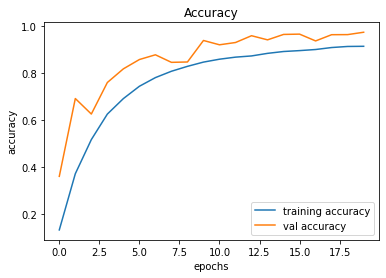

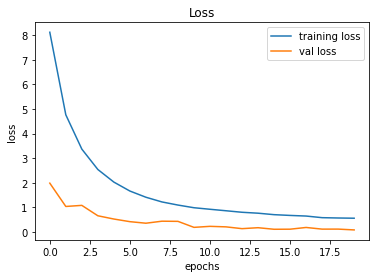

In [22]:
# plotting graphs for accuracy 

plt.figure(0)
plt.plot(H.history['accuracy'], label='training accuracy')
plt.plot(H.history['val_accuracy'], label='val accuracy')
plt.title('Accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()

plt.figure(1)
plt.plot(H.history['loss'], label='training loss')
plt.plot(H.history['val_loss'], label='val loss')
plt.title('Loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

**we can observe smooth decrease in train and validation losses & smooth increase in train and validation accuracy.**

# Model Testing

In [23]:
pred = model.predict_classes(X_test)

In [24]:
from sklearn.metrics import accuracy_score

print('Test Data accuracy: ',accuracy_score(y_test, pred)*100)

Test Data accuracy:  94.65558194774347


**Got 94.6% accuracy on testing data.**